<h1><center>Tarea 3:  Clasificación de texto con RNN

<center><strong><font size="5">CC6204 - Deep Learning</font></strong></center>


---
### Cuerpo Docente:

- Profesor: Iván Sipiran
- Ayudantes:
    - Camila Figueroa Acevedo
    - Gustavo Santelices
    - Sofia Capibara Chávez Bastidas
    - Victor Faraggi V.
### Estudiante:
- Maximiliano Varas González (maximilianovarasg@gmail.com)
- ---

En esta tarea van a crear una red neuronal que clasifique mensajes como spam o no spam. Lo primero es descargar la data:

In [1]:
!mkdir data
!python -m wget https://www.ivan-sipiran.com/downloads/spam.csv
!move *.csv data/

Ya existe el subdirectorio o el archivo data.



Saved under spam.csv
c:\Users\mvarasg\Documents\Universidad\CC6204 - Deep Learning\Tareas\T3\spam.csv
Se han movido         1 archivos.


Los datos vienen en un archivo CSV que contiene dos columnas "text" y "label". La columna "text" contiene el texto del mensaje y la columna "label" contiene las etiquetas "ham" y "spam". Un mensaje "ham" es un mensaje que no se considera spam.

# Tarea
El objetivo de la tarea es crear una red neuronal que clasifique los datos entregados. Para lograr esto debes:



*   Implementar el pre-procesamiento de los datos que creas necesario.
*   Particionar los datos en 70% entrenamiento, 10% validación y 20% test.
*   Usa los datos de entrenamiento y valiadación para tus experimentos y sólo usa el conjunto de test para reportar el resultado final.

Para el diseño de la red neuronal puedes usar una red neuronal recurrente o una red basada en transformers. El objetivo de la tarea no es obtener el performance ultra máximo, sino entender qué decisiones de diseño afectan la solución de un problema como este. Lo que si es necesario (como siempre) es que discutas los resultados y decisiones realizadas.



---
# Pre-procesamiento de data

Lo primero es cargar la data en un DataFrame:

In [2]:
import pandas as pd
import numpy as np

import random
import time
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import plotly.express as px
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import random
import time
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:

data = pd.read_csv('./data/spam.csv')
print(data.shape)
data.head(5)

(5572, 2)


,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


Veamos si hay elementos nulos en ambas columnas

In [4]:
data.isna().sum()

text     1
label    1
dtype: int64

En efecto, hay al menos una entrada en la columna `text` y en `label`. 

In [5]:
data[data.isna().any(axis=1)]

,text,label
2115,Well I wasn't available as I washob nobbing wi...,NaN
3035,NaN,-) ok. I feel like john lennon.


Hay elementos NaN en filas diferentes, por lo que se eliminan estas dos.

In [6]:
data = data.dropna()

Veamos que elementos hay en la columna label, debería solo estar "spam" y "ham".

In [7]:
data[(data['label']!='spam') & (data['label']!='ham')]

,text,label
44,Great! I hope you like your man well endowed. ...,#&gt
55,Do you know what Mallika Sherawat did yesterda...,URL&gt
78,Does not operate after &lt,#&gt
200,I sent you &lt,#&gt
202,Your account has been refilled successfully by...,DECIMAL&gt
...,...,...
5500,Love has one law,Make happy the person you love. In the same w...
5504,Wait . I will msg after &lt,#&gt
5513,Yes. Please leave at &lt,#&gt
5557,No. I meant the calculation is the same. That ...,#&gt


Se procede a eliminar los elementos que no tiene bien la etiqueta.

In [8]:
data = data[(data['label'] == 'spam') | (data['label'] == 'ham')]

Se procede a eliminar los signos de puntuación y se pasa todo el texto a minúsculas.

In [9]:
from string import punctuation
print(punctuation)
data['text'] = data['text'].str.lower()
data['text'] = data['text'].str.replace(f'[{punctuation}]', '', regex=True)
data = data[data['text']!=' '] #Se eliminan elementos con strings vacíos.
data['text'] = data['text'].str.replace('\n', ' ')
print(f'Al eliminar elementos NaN y vacíos la nueva dimensión de data es: {data.shape}.')
data.head(5)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Al eliminar elementos NaN y vacíos la nueva dimensión de data es: (5361, 2).


,text,label
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i dont think he goes to usf he lives aroun...,ham


In [10]:
def to_txt():
    with open('reviews.txt', 'w') as file:
        num_rows = len(data)
        for i, text in enumerate(data['text']):
            file.write(text)
            if i < num_rows - 1:
                file.write(' \n')  # Agregar '\n' solo si no es la última fila

    with open('labels.txt', 'w') as file:
        num_rows = len(data)
        for i, text in enumerate(data['label']):
            file.write(text)
            if i < num_rows - 1:
                file.write(' \n') 

Se pasan todas las palabras de la columna `text` a una lista.

In [11]:
lista_words = data['text'].tolist()
lista_words = [word for instancia in lista_words for word in instancia.split()]
print(f'En total se tienen {len(lista_words)} palabras.')

En total se tienen 81325 palabras.


In [12]:
from collections import Counter

counts = Counter(lista_words) #Diccionario donde la llave es la palabra y el valor es la frecuencia.
vocab = sorted(counts, key=counts.get, reverse=True) #Lista de palabras, ordenadas de mayor a menor.
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} #Diccionario con palabra como key y la posición de las más frecuentes como value.
print('Palabras únicas:', len(vocab_to_int))

Palabras únicas: 9328


In [13]:
data['text_num'] = data['text'].apply(lambda x: [vocab_to_int.get(word, word) for word in x.split()]) #Nueva columna con la lista con la representación numerica de cada palabras.
data.head(5)

,text,label,text_num
0,go until jurong point crazy available only in ...,ham,"[46, 436, 4264, 773, 728, 729, 64, 8, 1194, 88..."
1,ok lar joking wif u oni,ham,"[48, 301, 1356, 418, 6, 1782]"
2,free entry in 2 a wkly comp to win fa cup fina...,spam,"[45, 437, 8, 22, 4, 730, 871, 1, 175, 1783, 11..."
3,u dun say so early hor u c already then say,ham,"[6, 217, 143, 24, 353, 2828, 6, 156, 140, 58, ..."
4,nah i dont think he goes to usf he lives aroun...,ham,"[921, 2, 50, 99, 70, 438, 1, 922, 70, 1786, 21..."


Sigue reemplazar la columna label por valores numéricos. Se considera que spam:1 y ham:0.

In [14]:
data['label_encoded'] = data['label'].replace({'spam':1, 'ham':0})

### Padding

Se obtiene información estadística del largo de texto:

In [15]:
from statistics import median, mode
data['largo_text'] = data['text_num'].apply(len)
print("Largo promedio de las listas:", data['largo_text'].mean())
print("Mediana del largo de las listas:", median(data['largo_text']))
print("Moda del largo de las listas:", mode(data['largo_text']))
print('Max:', max(data['largo_text']))
print('Min:', min(data['largo_text']))


import matplotlib.pyplot as plt
import plotly.express as px

fig = px.histogram(data, x='largo_text', nbins=200, title='Distribución largo texto',marginal='box')

fig.show()

Largo promedio de las listas: 15.16974445066219
Mediana del largo de las listas: 12
Moda del largo de las listas: 6
Max: 171
Min: 1


Se define la siguiente estrategia:
- Se define un tamaño para las secuencias de texto: `largo_seq`
- Si el largo de una secuencia es mayor a `largo_seq`, se corta y se conservan las primeras `largo_seq` palabras.
- Si el largo de una secuencia es menor a `largo_seq`, se rellena con 0's al principio y se dejan al final las palabras de la secuencia, con el fin de tener una secuencia de largo `largo_seq`.  

In [16]:
# def padding_seq(df, largo_seq):
#     df = df.copy()
#     def padd_row(row, largo_seq):
#         if row['largo_text'] > largo_seq: # Se trunca
#             return row['text_num'][:largo_seq]
#         elif row['largo_text'] < largo_seq: # Se rellena con 0's
#             return [0] * (largo_seq - row['largo_text']) + row['text_num']
#         else: # Largo igual
#             return row['text_num']
#     df['text_num_padded'] = df.apply(padd_row, args=(largo_seq,), axis=1)
#     return df


def padding_seq(data, largo_seq):
    if isinstance(data, list):
        features = np.zeros((1, largo_seq), dtype=int)
        features[0, -len(data):] = np.array(data)[:largo_seq]
        return features
    elif isinstance(data, pd.DataFrame):
        df = data.copy()
        def padd_row(row, largo_seq):
            if row['largo_text'] > largo_seq: # Se trunca
                return row['text_num'][:largo_seq]
            elif row['largo_text'] < largo_seq: # Se rellena con 0's
                return [0] * (largo_seq - row['largo_text']) + row['text_num']
            else: # Largo igual
                return row['text_num']
        df['text_num_padded'] = df.apply(padd_row, args=(largo_seq,), axis=1)
        return df
    else:
        raise ValueError("El argumento debe ser una lista de números o un DataFrame.")



data_padding = padding_seq(data, 44)
data_padding

    

,text,label,text_num,label_encoded,largo_text,text_num_padded
0,go until jurong point crazy available only in ...,ham,"[46, 436, 4264, 773, 728, 729, 64, 8, 1194, 88...",0,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ok lar joking wif u oni,ham,"[48, 301, 1356, 418, 6, 1782]",0,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,free entry in 2 a wkly comp to win fa cup fina...,spam,"[45, 437, 8, 22, 4, 730, 871, 1, 175, 1783, 11...",1,28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,u dun say so early hor u c already then say,ham,"[6, 217, 143, 24, 353, 2828, 6, 156, 140, 58, ...",0,11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,nah i dont think he goes to usf he lives aroun...,ham,"[921, 2, 50, 99, 70, 438, 1, 922, 70, 1786, 21...",0,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
5567,this is the 2nd time we have tried 2 contact u...,spam,"[40, 9, 5, 384, 63, 38, 17, 526, 22, 185, 6, 6...",1,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40,..."
5568,will ì b going to esplanade fr home,ham,"[35, 106, 192, 73, 1, 1881, 843, 80]",0,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5569,pity was in mood for that soany other suggest...,ham,"[9325, 59, 8, 1191, 12, 19, 9326, 224, 9327]",0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5570,the guy did some bitching but i acted like id ...,ham,"[5, 521, 108, 109, 9328, 26, 2, 4206, 57, 391,...",0,26,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


---
# Particionamiento de datos

Se divide en 70% para el conjunto de train, 15% para val y 15% para test.

In [17]:
from sklearn.model_selection import train_test_split
proporcion_train = 0.7
proporcion_val = 0.15
proporcion_test = 0.15

# Dividimos el DataFrame en train, val y test
data_train, data_temp = train_test_split(data_padding, test_size=1 - proporcion_train, random_state=SEED)
data_val, data_test = train_test_split(data_temp, test_size=proporcion_test / (proporcion_val + proporcion_test), random_state=SEED)

# Imprime la longitud de los conjuntos para verificar la división
print("Número de ejemplos en train:", len(data_train))
print("Número de ejemplos en val:", len(data_val))
print("Número de ejemplos en test:", len(data_test))

Número de ejemplos en train: 3752
Número de ejemplos en val: 804
Número de ejemplos en test: 805


In [18]:
print("\t\t\tFeatures:")
print("Train set: \t\t{}".format(np.array(data_train['text_num_padded'].to_list()).shape),
      "\nValidation set: \t{}".format(np.array(data_val['text_num_padded'].to_list()).shape),
      "\nTest set: \t\t{}".format(np.array(data_test['text_num_padded'].to_list()).shape))

			Features:
Train set: 		(3752, 44) 
Validation set: 	(804, 44) 
Test set: 		(805, 44)


Se crean los dataloaders:

In [19]:
#Se pasa a tensores
train_x = torch.tensor(np.array(data_train['text_num_padded'].to_list()), dtype=torch.long)  # Usar dtype=torch.long
train_y = torch.tensor(data_train['label_encoded'].to_list(), dtype=torch.float32)

val_x = torch.tensor(np.array(data_val['text_num_padded'].to_list()), dtype=torch.long)  # Usar dtype=torch.long
val_y = torch.tensor(data_val['label_encoded'].values, dtype=torch.float32)

test_x = torch.tensor(np.array(data_test['text_num_padded'].to_list()), dtype=torch.long)  # Usar dtype=torch.long
test_y = torch.tensor(data_test['label_encoded'].values, dtype=torch.float32)



#TensorDataset
train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

batch_size = 50

#DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True, generator=torch.Generator().manual_seed(SEED))
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True, generator=torch.Generator().manual_seed(SEED))

In [20]:
train_y

tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [21]:
# Chequear si tenemos GPU
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [22]:
#Creamos la red neuronal
import torch.nn as nn

class SpamRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        
        super(SpamRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Capas embedding y LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        
        # dropout
        self.dropout = nn.Dropout(drop_prob)
        
        # Capa lineal y sigmoide
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
                
        #Tomamos solo el último valor de salida del LSTM
        lstm_out = lstm_out[:,-1,:]
                
        # dropout y fully-connected
        out = self.dropout(lstm_out)
        out = self.fc(out)
               
        # sigmoide
        sig_out = self.sig(out)
                  
        # retornar sigmoide y último estado oculto
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        # Crea dos nuevos tensores con tamaño n_layers x batch_size x hidden_dim,
        # inicializados a cero, para estado oculto y memoria de LSTM
        weight = next(self.parameters()).data
        
        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        # print("Hidden size:", hidden[0].size()) 
        return hidden

In [23]:
len(vocab_to_int)

9328

In [24]:
# Instanciamos la red
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1
embedding_dim = 100 
hidden_dim = 256
n_layers = 2

net = SpamRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SpamRNN(
  (embedding): Embedding(9329, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [25]:
def train(red, epochs, lr=0.001, batch_size=44, clip=5):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(red.parameters(), lr=lr)

    # Listas para almacenar las métricas en cada época
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Enviar red al GPU
    if train_on_gpu:
        red.cuda()

    red.train()

    for e in range(epochs):
        # Inicializar estado oculto
        h = red.init_hidden(batch_size)

        # Variables para calcular las métricas en cada época
        epoch_train_losses = []
        epoch_train_accs = []
        epoch_val_losses = []
        epoch_val_accs = []

        # Bucle para batchs
        for inputs, labels in train_loader:
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Crear nuevas variables para estados ocultos
            h = tuple([each.data for each in h])

            red.zero_grad()

            # Hacer pasada forward
            output, h = red(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            # Gradient clipping
            nn.utils.clip_grad_norm_(red.parameters(), clip)
            optimizer.step()

            # Calcular precisión en entrenamiento
            pred = torch.round(output.squeeze())
            correct_tensor = pred.eq(labels.float().view_as(pred))
            accuracy = correct_tensor.sum().item() / correct_tensor.numel()
            epoch_train_accs.append(accuracy)
            epoch_train_losses.append(loss.item())

        # Calcular promedio de pérdida y precisión en entrenamiento
        mean_train_loss = np.mean(epoch_train_losses)
        mean_train_acc = np.mean(epoch_train_accs)
        train_losses.append(mean_train_loss)
        train_accs.append(mean_train_acc)

        # Validation loss
        val_h = red.init_hidden(batch_size)
        red.eval()
        for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            output, val_h = red(inputs, val_h)
            loss = criterion(output.squeeze(), labels.float())
            epoch_val_losses.append(loss.item())

            # Calcular precisión en validación
            pred = torch.round(output.squeeze())
            correct_tensor = pred.eq(labels.float().view_as(pred))
            accuracy = correct_tensor.sum().item() / correct_tensor.numel()
            epoch_val_accs.append(accuracy)

        # Calcular promedio de pérdida y precisión en validación
        mean_val_loss = np.mean(epoch_val_losses)
        mean_val_acc = np.mean(epoch_val_accs)
        val_losses.append(mean_val_loss)
        val_accs.append(mean_val_acc)

        red.train()

    # Imprimir métricas de la época
        print(f"Época: {e + 1}/{ epochs}")
        print(f"Train Loss: {round(mean_train_loss,6)} \t Train Accuracy: {round(mean_train_acc,3)}")
        print(f"Val Loss: {round(mean_val_loss,6)} \t Val Accuracy: {round(mean_val_acc,3)}")
        print(7*"--------")
    return {
        'red_entrenada': red,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'n_epochs': epochs,
    }



In [26]:
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1
embedding_dim = 100 
hidden_dim = 256
n_layers = 2

net = SpamRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
dict_red1 = train(net, epochs = 10, lr = 0.001, batch_size = batch_size, clip = 5)

Época: 1/10
Train Loss: 0.246294 	 Train Accuracy: 0.906
Val Loss: 0.092244 	 Val Accuracy: 0.97
--------------------------------------------------------
Época: 2/10
Train Loss: 0.102682 	 Train Accuracy: 0.97
Val Loss: 0.052179 	 Val Accuracy: 0.989
--------------------------------------------------------
Época: 3/10
Train Loss: 0.098639 	 Train Accuracy: 0.972
Val Loss: 0.064075 	 Val Accuracy: 0.98
--------------------------------------------------------
Época: 4/10
Train Loss: 0.051295 	 Train Accuracy: 0.987
Val Loss: 0.045336 	 Val Accuracy: 0.988
--------------------------------------------------------
Época: 5/10
Train Loss: 0.031604 	 Train Accuracy: 0.991
Val Loss: 0.046025 	 Val Accuracy: 0.986
--------------------------------------------------------
Época: 6/10
Train Loss: 0.02251 	 Train Accuracy: 0.994
Val Loss: 0.047719 	 Val Accuracy: 0.982
--------------------------------------------------------
Época: 7/10
Train Loss: 0.011755 	 Train Accuracy: 0.996
Val Loss: 0.10726

In [27]:
def graficar(dict_model):
    train_losses = dict_model['train_losses']
    val_losses = dict_model['val_losses']
    train_accs = dict_model['train_accs']
    val_accs = dict_model['val_accs']
    n_epoch = dict_model['n_epochs']
    epoch = range(1,len(train_losses)+1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Dos gráficos en una fila
    axes[0].plot(epoch, train_losses, label='Train Losses', color='b')
    axes[0].plot(epoch, val_losses, label='Val Losses', color='r')
    axes[0].set_title('Función de Pérdidas')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(epoch, train_accs, label='Train_Acc', color='b')
    axes[1].plot(epoch, val_accs, label='Val_Acc', color='r')


    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.suptitle(f'Entrenamiento con {n_epoch} epocas.')
    plt.tight_layout()
    plt.show()

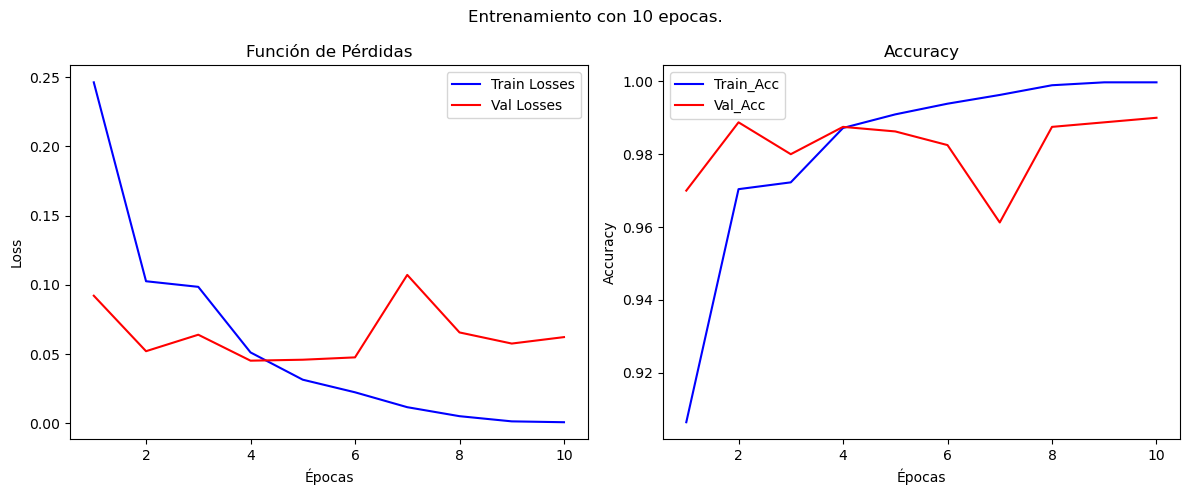

In [28]:
graficar(dict_red1)

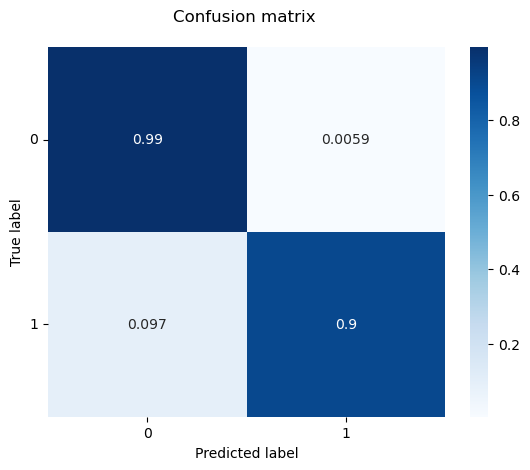

test_loss_avg: 0.153656	 test_accuracy: 97.391%.


(0.1536557835061103, 0.9739130434782609)

In [29]:
def evaluar_red(dict_red, test_loader=test_loader):

    red = dict_red['red_entrenada']
    criterion = nn.BCELoss()

    test_losses = []  # Track loss
    num_correct = 0
    all_preds = []
    all_labels = []

    # Inicializar estado oculto
    h = red.init_hidden(batch_size)  # Asegúrate de tener la variable batch_size definida

    red.eval()
    for inputs, labels in test_loader:

        h = tuple([each.data for each in h])

        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        output, h = red(inputs, h)

        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

        # Convertir probabilidades a clases (0,1)
        pred = torch.round(output.squeeze())

        # Comparar predicciones a labels
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy()) if train_on_gpu else np.squeeze(correct_tensor.numpy())
        num_correct += np.sum(correct)

        all_preds.extend(pred.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calcular estadísticas
    test_loss_avg = np.mean(test_losses)
    test_accuracy = num_correct / len(test_loader.dataset)

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    classes = list(range(len(cm)))

    # Crear un DataFrame de la matriz de confusión
    df = pd.DataFrame(cm, index=classes, columns=classes)

    # Crear un heatmap de la matriz de confusión
    g = sns.heatmap(df, annot=True, cmap="Blues")
    g.set_yticklabels(g.get_yticklabels(), rotation=0)

    plt.title('Confusion matrix \n')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.autoscale()
    plt.show()
    print(f"test_loss_avg: {round(test_loss_avg,6)}\t test_accuracy: {round(test_accuracy*100,3)}%.")

    return test_loss_avg, test_accuracy

evaluar_red(dict_red1)

In [30]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() 
    test_text = ''.join([c for c in test_review if c not in punctuation])
    
    test_words = test_text.split()
    
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])
    
    return test_ints

tokenize_review('hi we have an offer for u')

[[104, 38, 17, 115, 374, 12, 6]]

In [31]:
def predict(net, test_review, sequence_length):
      
    net.eval()
    
    test_ints = tokenize_review(test_review)
    print(test_ints)
    
    seq_length = sequence_length
    features = padding_seq(test_ints[0], seq_length)
    
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
      feature_tensor = feature_tensor.cuda()
      
    output, h = net(feature_tensor, h)
    
    pred = torch.round(output.squeeze())
    print('Valor predicho, antes del redondeo: {:.6f}'.format(output.item()))
    
    # print custom response based on whether test_review is pos/neg
    if(pred.item()==1):
      print('SPAM!')
    else:
      print('HAM!')

In [32]:
predict(net,'hi we have an offer for u call back asap', 44)

[[104, 38, 17, 115, 374, 12, 6, 16, 84, 988]]
Valor predicho, antes del redondeo: 0.000011
HAM!


In [33]:
def probar_test(df, largo_secuencia = 44):
    idx = df.index.tolist()
    random_idx = random.choice(idx)
    random_row = df.loc[random_idx]

    texto = random_row['text']
    label = random_row['label']

    # Imprimir los valores seleccionados
    print(f'{texto}  --->  {label}')
    predict(net, texto, sequence_length = largo_secuencia)


In [34]:
probar_test(data_test, 44)

ìï got wat to buy tell us then ì no need to come in again  --->  ham
[[234, 55, 134, 1, 221, 94, 197, 58, 106, 39, 78, 1, 61, 8, 188]]
Valor predicho, antes del redondeo: 0.000016
HAM!
